# Model Training


## Data Preparation

Data preparation is the process of transforming raw data into a form that is appropriate for modeling. It is a common requirement in machine learning and typically requires the use of specific techniques to prepare data, such as: data cleaning, feature selection, data transformation, and data splitting.

### Import Data and Required Packages

#### Importing Pandas, Numpy, Matplotlib, Seaborn, Scikit-Learn, and other required libraries


In [12]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

# Sklearn Import
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
)
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# Other Import
import warnings

### Import the CSV Data as Pandas DataFrame


In [13]:
# Read Data from CSV File and Store it in Pandas DataFrame Object
df = pd.read_csv("data/insurance.csv")

### Show Top 5 Records


In [14]:
# Check the first 5 rows of the data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Preparing X and Y variables


In [15]:
# Features except target variable (charges) are stored in X variable
X = df.drop(columns=["charges"], axis=1)

In [16]:
# Top 5 rows of X variable (features) are displayed below
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [17]:
# Categories in the different dataset variables
print("Categories in 'sex' variable:     ", end=" ")
print(df["sex"].unique())

print("Categories in 'smoker' variable:  ", end=" ")
print(df["smoker"].unique())

print("Categories in'region' variable:", end=" ")
print(df["region"].unique())

print("Categories in 'children' variable:     ", end=" ")
print(df["children"].unique())

Categories in 'sex' variable:      ['female' 'male']
Categories in 'smoker' variable:   ['yes' 'no']
Categories in'region' variable: ['southwest' 'southeast' 'northwest' 'northeast']
Categories in 'children' variable:      [0 1 3 2 5 4]


In [18]:
# Target variable (charges) is stored in y variable
y = df["charges"]

In [19]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

### Categorical columns

In [20]:
# define categorical columns
categorical_features = [feature for feature in X.columns if X[feature].dtype == "O"]

# print columns
print(
    f"We have {len(categorical_features)} categorical features : {categorical_features}"
)

We have 3 categorical features : ['sex', 'smoker', 'region']


### Numerical columns

In [21]:
# define numerical features
numeric_features = [feature for feature in X.columns if X[feature].dtype != "O"]

# print columns
print(f"We have {len(numeric_features)} numerical features : {numeric_features}")

We have 3 numerical features : ['age', 'bmi', 'children']


#### Discrete numerical columns

In [22]:
# Discrete numerical features
discrete_feature = [
    feature for feature in numeric_features if len(X[feature].unique()) < 25
]
print(f"We have {len(discrete_feature)} discrete features : {discrete_feature}")

We have 1 discrete features : ['children']


In [23]:
# Discrete numerical features are converted to object type for encoding purpose later on in the pipeline
X[discrete_feature] = X[discrete_feature].astype(object)

#### Continuous numerical columns

In [24]:
# Contunious numerical features
continuous_feature = [
    feature for feature in numeric_features if feature not in discrete_feature
]
print(f"We have {len(continuous_feature)} continuous features : {continuous_feature}")

We have 2 continuous features : ['age', 'bmi']


### Data preprocessing pipeline

In [25]:
numerical_features = ["age", "bmi"]
categorical_features = ["sex", "smoker", "region", "children"]

# Creating the pipeline objects for numerical and categorical features
numerical_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=False)),
    ]
)
categorical_pipeline = Pipeline(
    steps=[
        ("ordinal_encoder", OrdinalEncoder()),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

# Creating the column transformer object
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_pipeline", numerical_pipeline, numerical_features),
        (
            "categorical_pipeline",
            categorical_pipeline,
            categorical_features,
        ),
    ]
)

In [26]:
# Preprocess the data
X = preprocessor.fit_transform(X)

In [27]:
# Check the shape of X
X.shape

(1338, 6)

### Splitting the data into train and test sets

In [28]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# check the shape of X_train and X_test
X_train.shape, X_test.shape

((1070, 6), (268, 6))

## Create an Evaluate Function to give all metrics after model Training


In [29]:
def evaluate_model(true, predicted):
    """
    Evaluate the performance of a regression model.

    Parameters:
    true (array-like): The true values.
    predicted (array-like): The predicted values.

    Returns:
    tuple: A tuple containing the mean absolute error (MAE), root mean squared error (RMSE),
        and R-squared (R2) score.

    """
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [30]:
# Models to be used for training
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "Bayesian Ridge": BayesianRidge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "SVR": SVR(),
}

# Train and Evaluate the models
model_list = []
r2_list = []

# Iterate through each model and train and evaluate the model
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)  # Train model


    # Make predictions on train and test dataset using the trained model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Evaluate Train and Test dataset predictions
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(
        y_train, y_train_pred
    )


    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])


    print("Model performance for Training set")


    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print("----------------------------------")


    print("Model performance for Test set")


    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)


    print("=" * 35)
    print("\n")

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 6105.7893
- Mean Absolute Error: 4208.7620
- R2 Score: 0.7417
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5799.5871
- Mean Absolute Error: 4186.5089
- R2 Score: 0.7833


Lasso
Model performance for Training set
- Root Mean Squared Error: 6105.7898
- Mean Absolute Error: 4208.6791
- R2 Score: 0.7417
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5799.8127
- Mean Absolute Error: 4186.6211
- R2 Score: 0.7833


Ridge
Model performance for Training set
- Root Mean Squared Error: 6105.7973
- Mean Absolute Error: 4209.9047
- R2 Score: 0.7417
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5800.1536
- Mean Absolute Error: 4187.9534
- R2 Score: 0.7833


ElasticNet
Model performance for Training set
- Root Mean Squared Error: 7029.5232
- Mean Absolute Error: 5140.4700
- R2 Score:

Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 1882.1778
- Mean Absolute Error: 1024.8840
- R2 Score: 0.9755
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4631.7216
- Mean Absolute Error: 2511.4326
- R2 Score: 0.8618


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 919.7656
- Mean Absolute Error: 499.3392
- R2 Score: 0.9941
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4824.0411
- Mean Absolute Error: 2792.4773
- R2 Score: 0.8501


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 2715.0659
- Mean Absolute Error: 1527.7571
- R2 Score: 0.9489
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4516.6431
- Mean Absolute Error: 2547.8595
- R2 Score: 0.8686


AdaBoost Regressor
Model performance for Training set
- Root Mean Squared Error: 4831.4692
- Mean Ab

## Results


In [31]:
# Create a dataframe to compare the performance of each model
pd.DataFrame(
    list(zip(model_list, r2_list)), columns=["Model Name", "R2_Score"]
).sort_values(by=["R2_Score"], ascending=False)

,Model Name,R2_Score
11,Gradient Boosting Regressor,0.877994
9,CatBoosting Regressor,0.868598
7,Random Forest Regressor,0.861816
8,XGBRegressor,0.850103
10,AdaBoost Regressor,0.836256
5,K-Neighbors Regressor,0.833971
0,Linear Regression,0.783346
1,Lasso,0.783329
2,Ridge,0.783304
4,Bayesian Ridge,0.783257


### Gradient Boosting Regressor


In [32]:
# Gradient Boosting Regressor R2 Score
gradientboost_model = GradientBoostingRegressor()
gradientboost_model.fit(X_train, y_train)
y_pred = gradientboost_model.predict(X_test)
score = r2_score(y_test, y_pred)
print("R2 Score of Gradient Boosting Regressor: ", score)

R2 Score of Gradient Boosting Regressor:  0.8779726251291786


## Plot y_pred and y_test


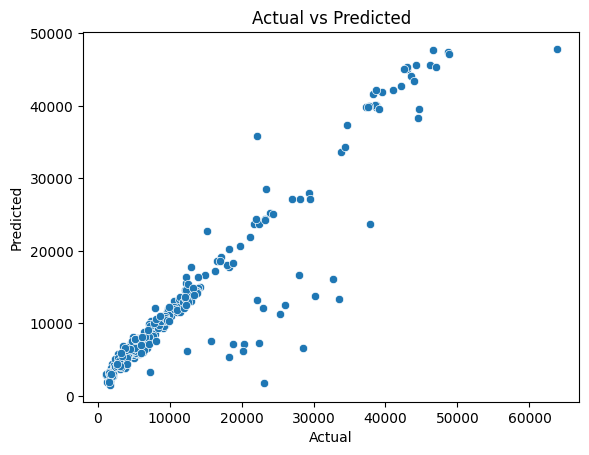

In [33]:
# Plot the Actual vs Predicted values as a scatterplot
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

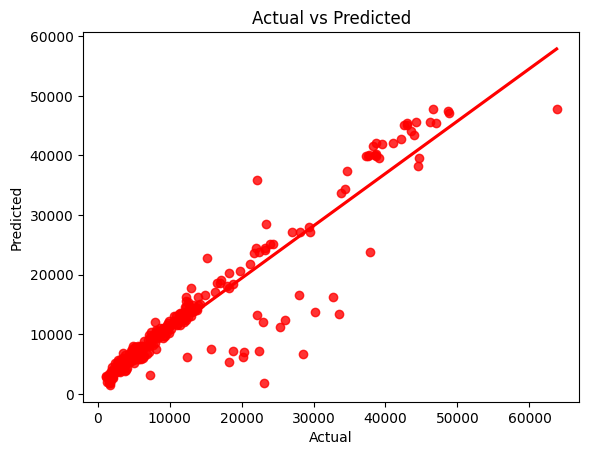

In [34]:
# Plot the Actual vs Predicted values as a regression plot
sns.regplot(x=y_test, y=y_pred, ci=None, color="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

## Difference between Actual and Predicted Values


In [35]:
# Dataframe to compare the Actual and Predicted values
pred_df = pd.DataFrame(

    {"Actual Value": y_test, "Predicted Value": y_pred, "Difference": y_test - y_pred}
)
# Display the dataframe
pred_df

,Actual Value,Predicted Value,Difference
764,9095.06825,11001.128629,-1906.060379
887,5272.17580,5840.174656,-567.998856
890,29330.98315,28001.980112,1329.003038
1293,9301.89355,9745.291602,-443.398052
259,33750.29180,33639.100981,111.190819
...,...,...,...
109,47055.53210,45431.423211,1624.108889
575,12222.89830,12465.025294,-242.126994
535,6067.12675,6974.336525,-907.209775
543,63770.42801,47862.047791,15908.380219
